In [1]:
import pandas as pd
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import missingno as msno
from datetime import timedelta
import os
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')
import src.utils.utils as util   # 기타 유틸리티 모듈

from src.subjectlist_alignment import reintubation as rnt
from src.subjectlist_alignment import imputation as imp

data_dir = '../outputs/reintubation_df.csv'

df = pd.read_csv(data_dir, index_col=0)

# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
df = util.to_datetime(df, time_cols)
print(df.shape)
df.head()

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9008, 18)


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,mvtime,reintubation_eventtime,reintubationtime
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN,2230.0,NaT,NaN
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN,5419.0,NaT,NaN
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN,NaN,NaT,NaN
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN,3930.0,2144-01-30 13:00:00,30.0
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,NaN,NaN,NaT,NaN


In [7]:
from importlib import reload
reload(imp)


<module 'src.subjectlist_alignment.imputation' from '/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철/src/subjectlist_alignment/imputation.py'>

3321

In [8]:
((df.mvtime > 1440) | (df.mvtime.isna())).sum()

7095

In [6]:
(df.mvtime <= 1440).sum()

1913

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9008 entries, 0 to 9007
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   subject_id              9008 non-null   int64         
 1   hadm_id                 9008 non-null   int64         
 2   int_stayid              7865 non-null   float64       
 3   admittime               9008 non-null   datetime64[ns]
 4   intubationtime          7865 non-null   datetime64[ns]
 5   int_itemid              7865 non-null   float64       
 6   int_weight              7865 non-null   float64       
 7   ext_stayid              6830 non-null   float64       
 8   extubationtime          6830 non-null   datetime64[ns]
 9   ext_itemid              6830 non-null   float64       
 10  ext_weight              6830 non-null   float64       
 11  extubationcause         6830 non-null   object        
 12  dischtime               9008 non-null   datetime64[ns

### 1. 마지막 시퀀스 발관시간 -> 퇴원시간/사망시각 대체

In [44]:
def init_marker(df):
    """
    결측치 처리 전에 'impute_marker'라는 칼럼을 생성. 어떤 결측값이 대체될 경우 이 칼럼에 마킹 됨.
    """
    df['marker'] = None

    return df


def insert_marker(row, log):
    """
    결측치 대체 등의 작업이 이루어진 행의 'marker' 칼럼에 수행된 작업 내용을 기입.
    """

    # 먼저, 'marker' 칼럼이 존재하는지 확인.
    if 'marker' not in row:
        print("Warning: 'marker' column not found. No action taken.")
        return row

    # 먼저, 행의 'marker' 칼럼이 비었는지 확인. 
    if pd.isna(row['marker']) or row['marker'] == None:
        # 'marker'가 비었으면 새로운 값 입력.
        row['marker'] = [log]
    else:
        # 'marker'가 비어있지 않으면 내용 추가.
        if not isinstance(row['marker'], list):   # 이미 기입된 값이 리스트가 아니라면 리스트로 변환
            row['marker'] = [row['marker']]   
        row['marker'].append(log)

    return row


def impute_final_extubation(group):
    """
    가장 마지막 발관 시간이 NULL일 경우, deathtime, 또는 dischtime 순으로 대체
    """
    last_idx = group.index[-1]

    # extubationtime 결측치 deathtime > dischtime 값으로 대체
    condition_deathtime = pd.isna(group.at[last_idx, 'extubationtime']) and pd.notna(group.at[last_idx, 'deathtime'])
    condition_dischtime = pd.isna(group.at[last_idx, 'extubationtime']) and pd.isna(group.at[last_idx, 'deathtime']) and pd.notna(group.at[last_idx, 'dischtime'])

    if condition_deathtime:
        group.at[last_idx, 'extubationtime'] = group.at[last_idx, 'deathtime']
        log = "deathtime imputation"
        group = group.apply(lambda row: insert_marker(row, log) if row.name == last_idx else row, axis=1)
    elif condition_dischtime:
        group.at[last_idx, 'extubationtime'] = group.at[last_idx, 'dischtime']
        log = "dischtime imputation"
        group = group.apply(lambda row: insert_marker(row, log) if row.name == last_idx else row, axis=1)

    return group



In [46]:
test_group_df = df.groupby(['subject_id', 'hadm_id'])
imputed_df_full_list = []
for _, group in test_group_df:
    test_func = impute_final_extubation(group)
    imputed_df_full_list.append(test_func)

imputed_df_full_list
imputed_df_full = pd.concat(imputed_df_full_list)

/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_20062/543971820.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imputed_df_full = pd.concat(imputed_df_full_list)
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_20062/543971820.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imputed_df_full = pd.concat(imputed_df_full_list)


In [2]:
# MAIN CODE

df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)

grouped_df = df.groupby(['subject_id', 'hadm_id'])
imputed_df_full_list = []

for _, group in grouped_df:
    group = imp.impute_final_extubation(group)
    imputed_df_full_list.append(group)

imputed_df_full = pd.concat(imputed_df_full_list)
imputed_df_full = rnt.get_mvtime(imputed_df_full)   # 대체값으로 mvtime 다시 구하기
imputed_df_full

/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_21949/3869831754.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imputed_df_full = pd.concat(imputed_df_full_list)
/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_21949/3869831754.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imputed_df_full = pd.concat(imputed_df_full_list)


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,mvtime,reintubation_eventtime,reintubationtime
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,None,2230.0,NaT,NaN
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,None,5419.0,NaT,NaN
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 17:31:00,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,[dischtime imputation],NaN,NaT,NaN
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,None,3930.0,2144-01-30 13:00:00,30.0
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,[dischtime imputation],NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,None,8416.0,2126-05-05 18:20:00,4430.0
9004,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,None,4269.0,NaT,NaN
9005,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,None,4201.0,NaT,NaN
9006,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,None,1155.0,NaT,NaN


In [3]:
imputed_df_full = rnt.get_mvtime(imputed_df_full)
imputed_df_full

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,mvtime,reintubation_eventtime,reintubationtime
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,None,2230.0,NaT,NaN
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,None,5419.0,NaT,NaN
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 17:31:00,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,[dischtime imputation],3628.0,NaT,NaN
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,None,3930.0,2144-01-30 13:00:00,30.0
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,[dischtime imputation],10005.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,None,8416.0,2126-05-05 18:20:00,4430.0
9004,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,None,4269.0,NaT,NaN
9005,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,None,4201.0,NaT,NaN
9006,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,None,1155.0,NaT,NaN


In [8]:
((imputed_df_full.mvtime > 1440) | (imputed_df_full.mvtime.isna())).sum()   # mvtime 24시간 초과거나 null 인 경우 (살리는 케이스)

6823

In [5]:
(imputed_df_full.mvtime <= 1440).sum()

2185

In [7]:
(imputed_df_full.mvtime.notna()).sum()

7621

<Axes: >

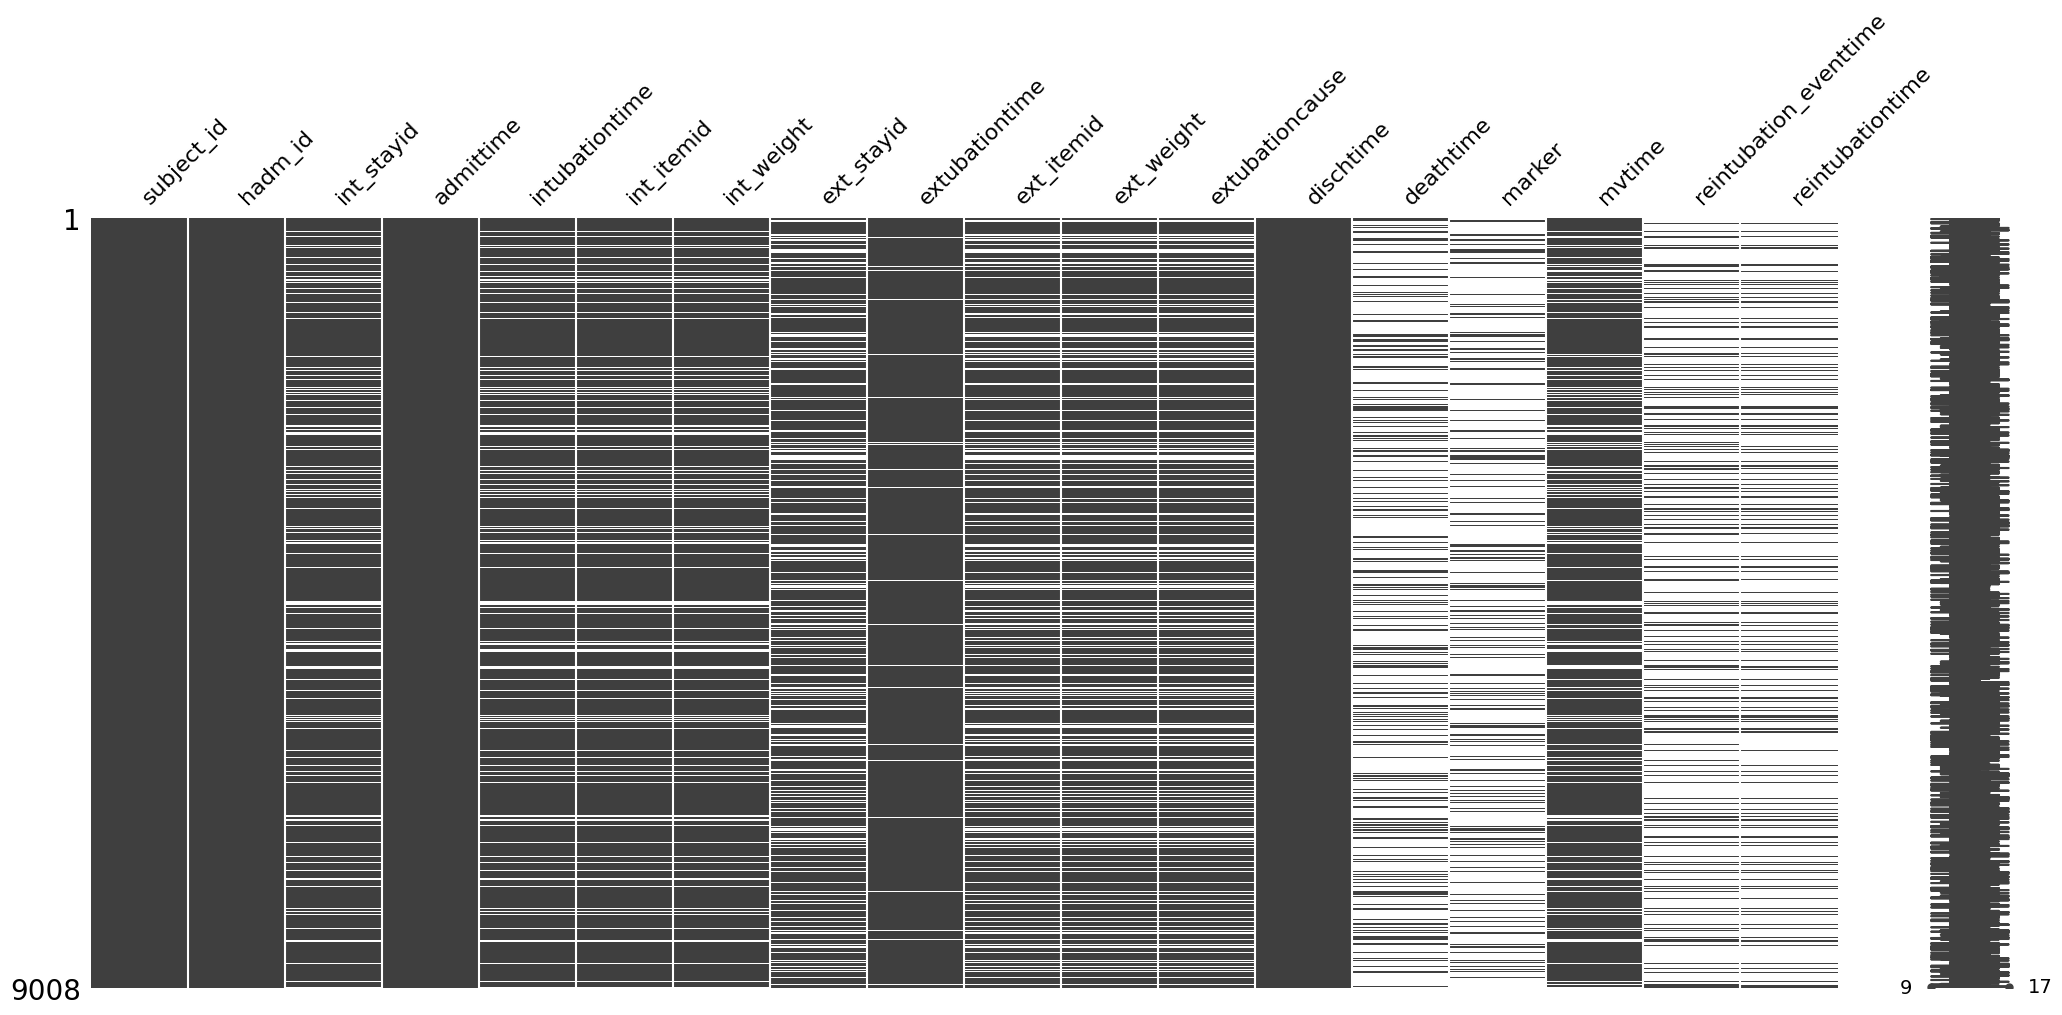

In [9]:
msno.matrix(imputed_df_full)

In [32]:
df[(df.subject_id == 19931382) & (df.hadm_id == 25407424)].iloc[-1].extubationtime

Timestamp('2150-12-22 09:10:00')

In [45]:
test = df[df.subject_id == 10004401]
test = test.groupby(['subject_id', 'hadm_id'])

imputed_data = []  # Create an empty list to collect the imputed data

for _, group in test:
    group_after = impute_final_extubation(group)
    imputed_data.append(group_after)
imputed_df = pd.concat(imputed_data)
imputed_df

/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_20062/3634122801.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imputed_df = pd.concat(imputed_data)


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,mvtime,reintubation_eventtime,reintubationtime
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 17:31:00,NaN,NaN,NaN,2144-04-13 17:31:00,NaN,[dischtime imputation],NaN,NaT,NaN
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaN,NaN,3930.0,2144-01-30 13:00:00,30.0
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,NaN,NaN,NaN,2144-02-06 11:45:00,NaN,[dischtime imputation],NaN,NaT,NaN
